In [1]:
import time, datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

In [2]:
df1 = pd.read_excel('./data/timeLine.xlsx')
df1 = df1.fillna(0)

In [3]:
# 疫情高峰时期
a = (df1['累计确诊'] - df1.shift(1)['累计确诊']).iloc[1:].tolist()
df1.iloc[a.index(max((df1['累计确诊'] - df1.shift(1)['累计确诊']).iloc[1:])) + 1]

日期       2020-12-10
累计确诊       70564412
治愈人数    4.79291e+07
死亡人数        1585977
Name: 323, dtype: object

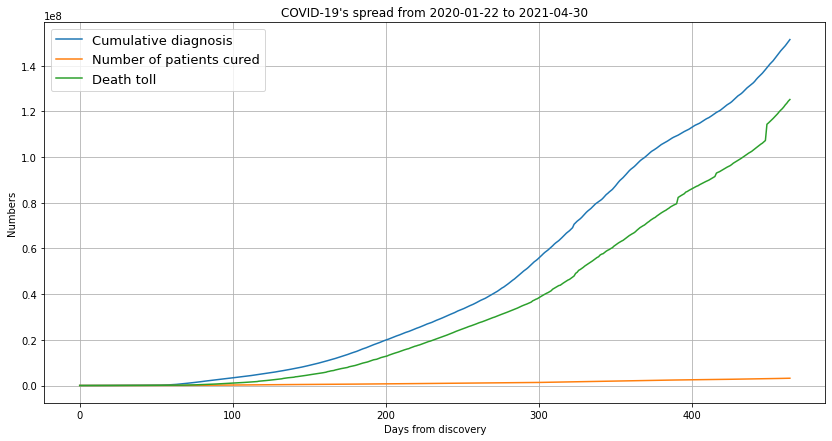

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1.index, df1['累计确诊'], label='Cumulative diagnosis')
ax.plot(df1.index, df1['死亡人数'], label='Number of patients cured')
ax.plot(df1.index, df1['治愈人数'], label='Death toll')
ax.set_xlabel('Days from discovery')
ax.set_ylabel('Numbers')
ax.legend(fontsize=13)
ax.set_title("COVID-19's spread from 2020-01-22 to 2021-04-30")
ax.grid(True)
plt.show()

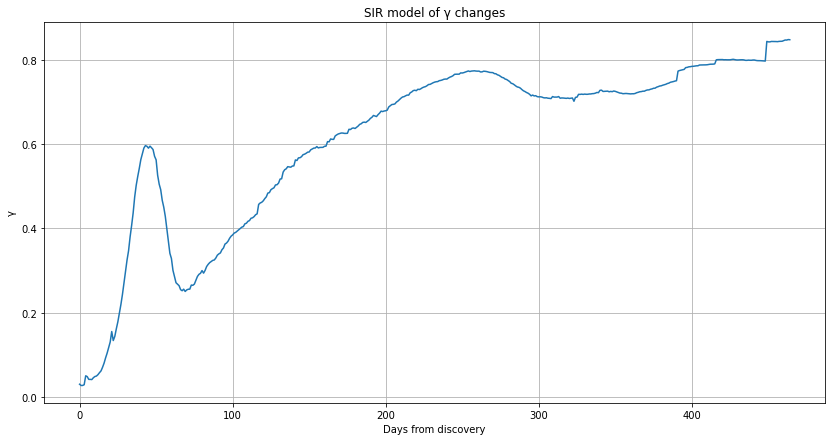

In [5]:
gammaguess = (df1["治愈人数"] + df1["死亡人数"]) / df1["累计确诊"]
gamma = gammaguess.mean()
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1.index, gammaguess)
ax.set_title("SIR model of γ changes")
ax.set_xlabel('Days from discovery')
ax.set_ylabel('γ')
ax.grid(True)
plt.show()

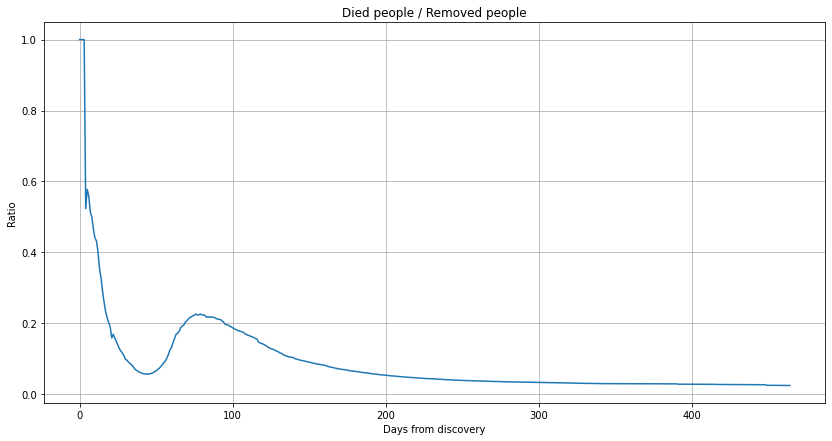

In [6]:
'''
死亡人数比移除人数比例
'''
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1.index, df1['死亡人数'] / (df1['治愈人数'] + df1['死亡人数']))
ax.set_xlabel('Days from discovery')
ax.set_ylabel('Ratio')
ax.set_title("Died people / Removed people")
ax.grid(True)
plt.show()

In [7]:
start_time = df1['日期'][0]
end_time = df1['日期'][max(df1.index)]
nContact, gamma = int(5), 1/14
died_cure_radio = 0.02
t = np.arange(0, 800)
N = 7000000000
S0 = 1 - 0.000000082     #根据治愈患者第一次出现的时间计算的比例
R0 = 2.428571428571429e-9
I0 = 7.957142857142857e-8

In [8]:
'''
SIR模型的参数确定
'''
class estimationInfectionProb():
    def __init__(self, estUsedTimeIndexBox, nContact, gamma):
        self.timeRange = np.array([i for i in range(estUsedTimeIndexBox[0], estUsedTimeIndexBox[1] + 1)])
        self.nContact, self.gamma = nContact, gamma
        self.dataStartTimeStep = 0

    def setInitSolution(self, x0):
        self.x0 = 0.04

    def costFunction(self, infectionProb):
        res = np.array(np.exp((infectionProb * self.nContact - self.gamma) * self.timeRange) - \
                       df1.loc[self.timeRange - self.dataStartTimeStep, '累计确诊'])
        return (res ** 2).sum() / self.timeRange.size

    def optimize(self):
        self.solution = minimize(self.costFunction, self.x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
        return self.getSolution()

    def getSolution(self):
        return self.solution.x

    def getBasicReproductionNumber(self):
        self.basicReproductionNumber = self.nContact * self.solution.x[0] / (self.gamma)
        print("basic reproduction number:", self.basicReproductionNumber)
        return self.basicReproductionNumber

# 计算beta
startTime = datetime.datetime.strptime(start_time, "%Y-%m-%d")
estUsedTimeBox = [datetime.datetime.strptime(start_time, "%Y-%m-%d"),
                  datetime.datetime.strptime(end_time, "%Y-%m-%d")]
estUsedTimeIndexBox = [(t - startTime).days for t in estUsedTimeBox]
estInfectionProb = estimationInfectionProb(estUsedTimeIndexBox, nContact, gamma)
estInfectionProb.setInitSolution(0.04)
infectionProb = estInfectionProb.optimize()
# SIR参数
beta = float(infectionProb) * nContact
σ = beta / gamma
print("beta={},gama={},σ={}".format(beta, gamma, σ))

beta=0.11317970171570754,gama=0.07142857142857142,σ=1.5845158240199058


疫情结束的时间:2022-04-01 00:00:00,全球最终感染的人数:548848215,全球因为新冠疫情最终死亡的人数:88693954


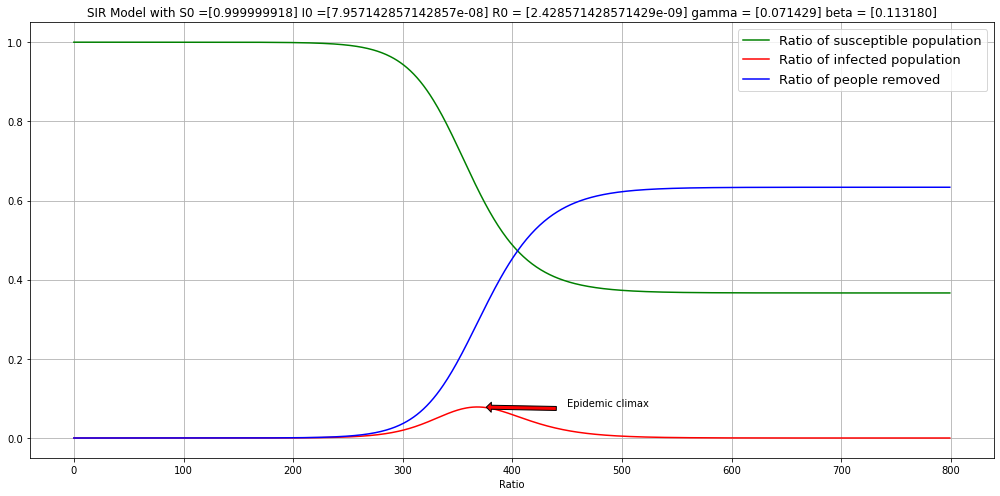

In [9]:
'''
SIR模型的微分方程
'''

def SIR(sir, t, beta, gamma):
    S, I, R = sir
    dsdt = - beta * S * I
    didt = beta * S * I - gamma * I
    drdt = gamma * I
    return [dsdt, didt, drdt]

# 求解时序变化
result = odeint(SIR, [S0, I0, R0], t, args=(beta, gamma))
St, It, Rt = result[:, 0], result[:, 1], result[:, 2]

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(t, St, c="g", label="Ratio of susceptible population")
ax.plot(t, It, c="r", label="Ratio of infected population")
ax.plot(t, Rt, c="b", label="Ratio of people removed")
ax.legend(fontsize=13)
ax.grid(True)
ax.set_title(
    "SIR Model with S0 =[{}] I0 =[{}] R0 = [{}] gamma = [{:2f}] beta = [{:2f}]".format(S0, I0, R0, gamma, beta))

ax.set_xlabel('Days from {}'.format(start_time))
ax.set_xlabel('Ratio'.format(start_time))
'''
SIR模型预测
'''
need_day = datetime.timedelta(days=int(np.sum(It >= 0))).days
over_Time = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days=int(np.sum(It >= 0)))
max_infected_day = It.tolist().index(max(It))
number_of_infected = int(np.ceil(np.max(It) * N))
number_of_died = int(np.ceil(np.max(Rt) * N * died_cure_radio))
ax.annotate('Epidemic climax', (max_infected_day, It[max_infected_day]), xytext=(90, 0.3),textcoords='offset points',arrowprops={
    'headwidth': 10,
    'headlength': 5,
    'width': 4,
    'facecolor': 'r',
    'shrink': 0.1,
})
print('疫情结束的时间:{},全球最终感染的人数:{},全球因为新冠疫情最终死亡的人数:{}'.format(over_Time, number_of_infected, number_of_died))
plt.tight_layout()
plt.show()

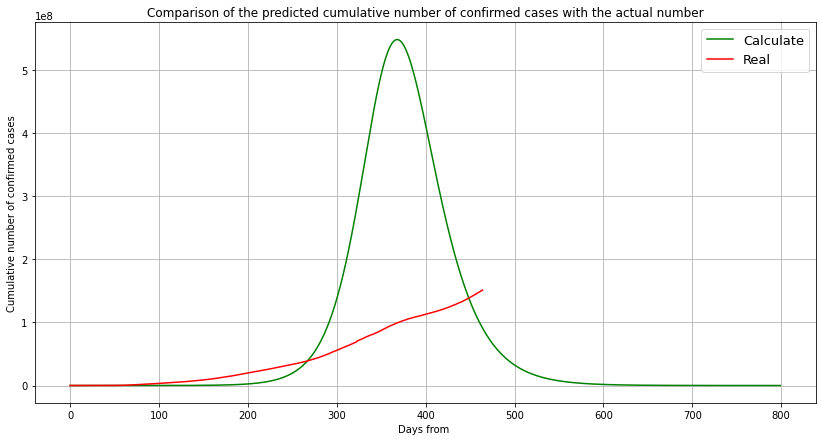

In [10]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(t, N * It, c="g", label="Calculate")
ax.plot(df1.index, df1['累计确诊'], c="r", label="Real")
ax.set_title("Comparison of the predicted cumulative number of confirmed cases with the actual number")
ax.set_xlabel('Days from '.format(start_time))
ax.set_ylabel('Cumulative number of confirmed cases')
ax.legend(fontsize=13)
ax.grid(True)
plt.show()

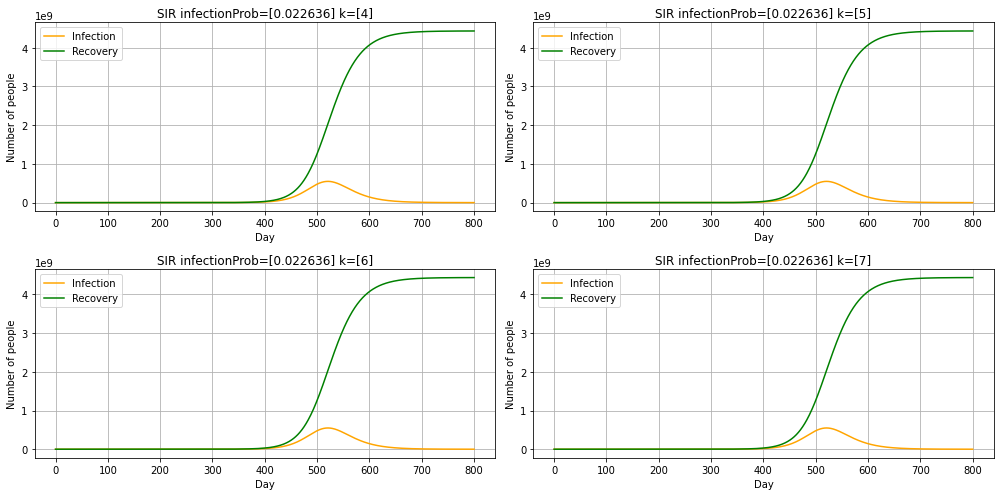

In [11]:
class SIRModelPredict():
    def __init__(self, N, beta, gamma, k):
        self.beta, self.gamma, self.N, self.k = beta, gamma, N, k
        self.t = np.linspace(0, 800, 801)
        self.setInitCondition()

    def odeModel(self, population, t):
        diff = np.zeros(3)
        s, i, r = population
        diff[0] = - self.beta * s * i / self.N
        diff[1] = self.beta * s * i / self.N - self.gamma * i
        diff[2] = self.gamma * i
        return diff

    def setInitCondition(self):
        self.populationInit = [self.N - 1, 1, 0]

    def solve(self):
        self.solution = odeint(self.odeModel, self.populationInit, self.t)
        return self.solution


fig, ax = plt.subplots(2, 2, figsize=(14, 7))
i,j = 0,0
# 接触人数减少的效果
for k in range(4, 8):
    obj = SIRModelPredict(N, beta, gamma, k)
    solution = obj.solve()
    ax[i][j].plot(solution[:, 1], color='orange', label='Infection')
    ax[i][j].plot(solution[:, 2], color='green', label='Recovery')
    ax[i][j].set_title("SIR infectionProb=[{:2f}] k=[{}]".format(float(infectionProb), k))
    ax[i][j].legend()
    ax[i][j].set_xlabel('Day')
    ax[i][j].set_ylabel('Number of people')
    ax[i][j].grid(True)
    if i == 0 and j == 0:
        j = j + 1
    elif i == 0 and j == 1:
        i, j = 1, 0
    elif i == 1 and j == 0:
        i, j = 1, 1
    else:
        i, j = 0, 0

plt.tight_layout()
plt.show()